In [1]:
import random
import numpy as np
import torch
import pandas as pd
from MetaMF import *
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1) #set random seed for cpu
torch.cuda.manual_seed(1) #set random seed for current gpu
torch.cuda.manual_seed_all(1) #set random seed for all gpus

In [3]:
if torch.cuda.is_available():
    use_cuda = True
    torch.cuda.set_device(7)
else:
    use_cuda = False
print("CUDA available? " + str(use_cuda))
if use_cuda:
    print("Current device: %d" % torch.cuda.current_device())

CUDA available? True
Current device: 7


# Utility Functions
## Read Dataset

In [4]:
def read_dataset(path):
    trainset = pd.read_csv(path + ".train.rating", sep="\t", header=None).to_records(index=False).tolist()
    valset = pd.read_csv(path + ".valid.rating", sep="\t", header=None).to_records(index=False).tolist()
    testset = pd.read_csv(path + ".test.rating", sep="\t", header=None).to_records(index=False).tolist()
    
    return trainset, valset, testset

def read_usergroups(path):
    low_users = pd.read_csv(path + "_low.userlist", header=None, squeeze=True).values.tolist()
    med_users = pd.read_csv(path + "_med.userlist", header=None, squeeze=True).values.tolist()
    high_users = pd.read_csv(path + "_high.userlist", header=None, squeeze=True).values.tolist()
    
    return low_users, med_users, high_users

def read_useranditemlist(path):
    userlist = pd.read_csv(path + ".userlist", header=None, squeeze=True).values.tolist()
    itemlist = pd.read_csv(path + ".itemlist", header=None, squeeze=True).values.tolist()
    
    return userlist, itemlist

## Helpers for Model Training

In [5]:
def batchtoinput(batch, use_cuda):
    users = []
    items = []
    ratings = []
    for example in batch:
        users.append(example[0])
        items.append(example[1])
        ratings.append(example[2])
    users = torch.tensor(users, dtype=torch.int64)
    items = torch.tensor(items, dtype=torch.int64)
    ratings = torch.tensor(ratings, dtype=torch.float32)
    if use_cuda:
        users = users.cuda()
        items = items.cuda()
        ratings = ratings.cuda()
    return users, items, ratings

def getbatches(traindata, batch_size, use_cuda, shuffle):
    dataset = traindata.copy()
    if shuffle:
        random.shuffle(dataset)
    for batch_i in range(0,int(np.ceil(len(dataset)/batch_size))):
        start_i = batch_i*batch_size
        batch = dataset[start_i:start_i+batch_size]
        yield batchtoinput(batch, use_cuda)
        
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)
        
def get_eval(ratlist, predlist):
    mae = np.mean(np.abs(ratlist-predlist))
    mse = np.mean(np.square(ratlist-predlist))       
    return  mae, mse

## Other Functions

In [6]:
def sampling_procedure(dataset, beta):
    dataframe = pd.DataFrame(dataset, columns=["user_id", "item_id", "rating"])
    n_samples = np.ceil(dataframe.groupby("user_id").size() * (beta)).astype(int)
    
    new_dataset = []
    for uid, group in dataframe.groupby("user_id"):
        new_dataset.extend(group.sample(n=n_samples.loc[uid]).to_records(index=False).tolist())
    return new_dataset

In [22]:
def run(path, traindata, valdata, testdata, userlist, itemlist, low, med, high, hyperparameters, betas=None, disable_meta_learning=False, save=False):
    results_dict = dict()
    if betas is None:
        betas = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    for beta in betas:
        results_dict["beta"] = beta
        model_name = "beta_" + str(int(beta*100)) + "p"  
        print("==========================")
        print(model_name)
        print("==========================")
        R_train_beta = sampling_procedure(traindata, 0.1)
        
        train_loss, validation_loss = [], []
        net = MetaMF(len(userlist), len(itemlist))
        if disable_meta_learning:
            net.disable_meta_learning()
        
        net.apply(weights_init)
        if use_cuda:
            net.cuda()
            
        optimizer = optim.Adam(net.parameters(), lr=hyperparameters["lr"], weight_decay=hyperparameters["lambda"])
        batch_size = hyperparameters["batch_size"]
        n_epochs = hyperparameters["n_epochs"]
        
        for epoch in range(n_epochs):
            net.train()
            error = 0
            num = 0
            for k, (users, items, ratings) in enumerate(getbatches(R_train_beta, batch_size, use_cuda, True)):
                optimizer.zero_grad()
                pred = net(users, items)

                loss = net.loss(pred, ratings)
                loss.backward()
                nn.utils.clip_grad_norm_(net.parameters(), 5)
                optimizer.step()
                error += loss.detach().cpu().numpy()*len(users)
                num += len(users)
            train_loss.append(error/num)
            
            net.eval()
            groundtruth, estimation = [], []
            for users, items, ratings in getbatches(valdata, batch_size, use_cuda, False):
                predictions = net(users, items)
                estimation.extend(predictions.tolist())
                groundtruth.extend(ratings.tolist())
            mae, mse = get_eval(np.array(groundtruth), np.array(estimation))
            validation_loss.append(mse)
            
            print('Epoch {}/{} - Training Loss: {:.3f}, Validation Loss: {:.3f}'.format(epoch+1, n_epochs, error/num, mse))
            
            if epoch+1 == n_epochs:
                if save:
                    torch.save(net, path + "/" + model_name + '.model')
                    print("Saved Model to " + path)
                
                results_dict["train_mse_all"] = [error / num]
                results_dict["val_mse_all"] = [mse]
        
        net.eval()
        plt.figure()
        plt.plot(range(n_epochs), train_loss, label="Train")
        plt.plot(range(n_epochs), validation_loss, label="Val")
        plt.legend()
        plt.ylabel("MSE")
        plt.xlabel("Epoch")
        plt.tight_layout()
        
        groundtruth, estimation = [], []
        group_groundtruth = defaultdict(list)
        group_estimation = defaultdict(list)
        for users, items, ratings in getbatches(testdata, batch_size, use_cuda, False):
            predictions = net(users, items)
            estimation.extend(predictions.tolist())
            groundtruth.extend(ratings.tolist())
            
            for uid, iid, r, p in zip(users.cpu().numpy(), items.cpu().numpy(), ratings.cpu().numpy(), pred.detach().cpu().numpy()):
                if uid in low:
                    group_groundtruth["low"].append(r)
                    group_estimation["low"].append(p)
                elif uid in med:
                    group_groundtruth["med"].append(r)
                    group_estimation["med"].append(p)
                elif uid in high:
                    group_groundtruth["high"].append(r)
                    group_estimation["high"].append(p)
        
        test_mae, test_mse = get_eval(np.array(groundtruth), np.array(estimation))
        low_mae, low_mse = get_eval(np.array(group_groundtruth["low"]), np.array(group_estimation["low"]))
        med_mae, med_mse = get_eval(np.array(group_groundtruth["med"]), np.array(group_estimation["med"]))
        high_mae, high_mse = get_eval(np.array(group_groundtruth["high"]), np.array(group_estimation["high"]))
        
        results_dict["test_mse_all"] = [test_mse]
        results_dict["test_mae_all"] = [test_mae]
        results_dict["test_mse_low"] = [low_mse]
        results_dict["test_mae_low"] = [low_mae]
        results_dict["test_mse_med"] = [med_mse]
        results_dict["test_mae_med"] = [med_mae]
        results_dict["test_mse_high"] = [high_mse]
        results_dict["test_mae_high"] = [high_mae]
        
        if save:
            plt.savefig(path + "/" + model_name + ".png", dpi=300)
            pd.DataFrame(results_dict).to_csv(path + "/results.csv", index=False)
            print("Saved Results to " + path)

beta_10p
Epoch 1/10 - Training Loss: 1.624, Validatoin Loss: 1.134
Epoch 2/10 - Training Loss: 0.860, Validatoin Loss: 1.075
Epoch 3/10 - Training Loss: 0.568, Validatoin Loss: 1.147
Epoch 4/10 - Training Loss: 0.416, Validatoin Loss: 1.174
Epoch 5/10 - Training Loss: 0.331, Validatoin Loss: 1.207
Epoch 6/10 - Training Loss: 0.272, Validatoin Loss: 1.227
Epoch 7/10 - Training Loss: 0.242, Validatoin Loss: 1.214
Epoch 8/10 - Training Loss: 0.220, Validatoin Loss: 1.239
Epoch 9/10 - Training Loss: 0.203, Validatoin Loss: 1.276
Epoch 10/10 - Training Loss: 0.193, Validatoin Loss: 1.240
Saved Model to experiments/meta/ml
Saved Results to experiments/meta/ml


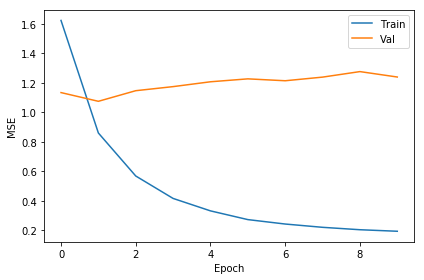

In [21]:
train, val, test = read_dataset("data/ml")
users, items = read_useranditemlist("data/ml")
low, med, high = read_usergroups("data/ml")
run("experiments/meta/ml", train, val, test, users, items, low, med, high, betas=[0.1], save=True, 
    hyperparameters={"lr": 0.0001, "lambda": 0.001, "batch_size": 64, "n_epochs": 10})